In [1]:
import gym
import numpy as np
import random
from collections import deque

from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *
from bigdl.nn.initialization_method import *

from datetime import datetime
from to_rdd import to_RDD

from rl.criterion import *

import to_rdd

from keras import models
from keras.layers import Dense
from keras import optimizers

import matplotlib.pyplot as plt

init_engine()

Using TensorFlow backend.


In [2]:
class PGAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.01,
                load=False, load_path='/tmp/model.bigl'):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma  # discount rate
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.value_func = self._build_vf()
        if load:
            self.model = self.model.load(load_path)
        

    def _build_model(self):
        model = Sequential()
        
        model.add(Linear(self.state_size, 200))
        model.add(Tanh())
        
        model.add(Linear(200, 110))
        model.add(Tanh())
        
        model.add(Linear(110,60))
        model.add(Tanh())

        model.add(Linear(60, self.action_size))
        model.add(SoftMax())
        return model
    
    def _build_vf(self):
        model = models.Sequential()
        model.add(Dense(100, input_dim=self.state_size, activation='tanh'))
        model.add(Dense(25, activation='tanh'))
        model.add(Dense(6, activation='linear'))
        model.compile(loss='mse',
                      optimizer=optimizers.Adam(lr=0.001))
        return model
    
    def train_val_func(self, minibatch):
        for state, action, reward, next_state in minibatch:
            action = int(action[0])-1
            target = reward
            if reward == 0:
                target = (reward + self.gamma *
                          np.amax(self.value_func.predict(np.reshape(next_state, [1, state_size]))[0]))
            target_f = self.value_func.predict(np.reshape(next_state, [1, state_size]))
            target_f[0][action] = target
            self.value_func.fit(np.reshape(state, [1, state_size]), target_f, epochs=1, verbose=0)



    def act(self, state):
        result = self.model.forward(state)
        return np.random.choice(range(6), p=result)
    
    def save(self,name='model'+str(datetime.now())[:-7]+'bigdl'):
        self.model.save("/tmp/"+name)

In [3]:
def play_game(agent, render=False, report_score=False):
    state = env.reset()
    done = False
    actions = []
    rewards = []
    states = [np.zeros(agent.state_size)]
    score = [0,0]
    while not done:
        if render == True:
            env.render()
        states.append(state)
        action = agent.act(state)
        actions.append(action)

        state, reward, done, _ = env.step(action)
        if reward == -1:
            score[0] += 1
        elif reward == 1:
            score[1] += 1
        rewards.append(reward)
    if report_score:
        print('Score is {} : {}'.format(score[0], score[1]))
    return states[1:], actions, rewards

In [4]:
def get_values(agent, states):
    result = []
    for state in states:
        values = agent.value_func.predict(np.reshape(state, [1, agent.state_size]))[0]
        prediction = agent.model.forward(state)
        result.append(np.sum(values*prediction))
    return result

In [5]:
def running_reward(actions, rewards, st_values, gamma):
    result = []
    run_rew = 0
    for action, reward, st_value in list(zip(actions, rewards, st_values))[::-1]:
        if reward !=0:
            run_rew=0
        run_rew = run_rew*gamma + reward
        result.append([action+1, (run_rew-st_value)])
    return np.vstack(result[::-1])

In [6]:
def play_n_games(agent, n=20, report_score=False):
    X_batch = np.array(np.zeros(agent.state_size))
    y_batch = np.array([0, 0])
    results = []
    for i in range(n):
        a, b, c = play_game(agent, report_score=report_score)
        X_batch = np.vstack((X_batch, a))
        st_values = get_values(agent, a)
        y_batch = np.vstack((y_batch, running_reward(b, c, st_values, agent.gamma)))
        results = np.append(results, c)
    return X_batch[1:], y_batch[1:], results

In [7]:
env = gym.make('Pong-ram-v0')
sc = SparkContext.getOrCreate(create_spark_conf())
state_size = env.observation_space.shape[0]
action_size = 6
agent = PGAgent(state_size, action_size,learning_rate=0.0001)
#weights = agent.model.get_weights()
#weights[2] = np.zeros([1, 200])
#weights[3] = np.zeros(1)
#agent.model.set_weights(weights)

[2017-12-10 10:25:57,616] Making new env: Pong-ram-v0


creating: createSequential
creating: createLinear
creating: createTanh
creating: createLinear
creating: createTanh
creating: createLinear
creating: createTanh
creating: createLinear
creating: createSoftMax


In [14]:
t = 3251
batch_size_MA = 8000
batch_sizes_mean = []

In [15]:
agent.value_func = models.load_model('vf_func3250')
agent.model = Model.load('Actor_critic_Pong3250')

In [ ]:
while True:
    X_batch, y_batch, results = play_n_games(agent, n=5, report_score=True)
    vf_batch = random.sample(list(zip(X_batch[:-1], y_batch[:-1], results[:-1], X_batch[1:])), 255)
    vf_batch.append([X_batch[-1], y_batch[-1], results[-1], X_batch[0]])
    agent.train_val_func(vf_batch[::-1])
    rdd_sample = to_rdd.to_RDD(X_batch, y_batch, sc)
    batch_size = X_batch.shape[0] - X_batch.shape[0]%4
    batch_size_MA = batch_size_MA*0.99 + batch_size*0.01
    batch_sizes_mean.append(batch_size_MA)
    print(t, np.sum(results)/5, batch_size, batch_size_MA)
    if np.sum(results)/5 >= 2:
        break
    
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=PGCriterion(is_clip=True),
                                  optim_method=Adam(learningrate=0.0002),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    agent.model = optimizer.optimize()
    agent.model.evaluate()
    if t % 50 == 0:
        save_name = 'Actor_critic_Pong'+str(t)
        agent.model.save(save_name)
        agent.value_func.save('vf_func'+str(t))
    t += 1

Score is 21 : 1


In [34]:
while True:
    X_batch, y_batch, results = play_n_games(agent, n=5, report_score=True)
    vf_batch = random.sample(list(zip(X_batch[:-1], y_batch[:-1], results[:-1], X_batch[1:])), 255)
    vf_batch.append([X_batch[-1], y_batch[-1], results[-1], X_batch[0]])
    agent.train_val_func(vf_batch[::-1])
    rdd_sample = to_rdd.to_RDD(X_batch, y_batch, sc)
    batch_size = X_batch.shape[0] - X_batch.shape[0]%4
    batch_sizes.append(batch_size)
    batch_sizes_mean.append(np.mean(batch_sizes))
    print(t, np.sum(results)/5, batch_size,np.mean(batch_sizes))
    if np.sum(results)/5 >= 2:
        break
    
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=PGCriterion(),
                                  optim_method=Adam(learningrate=0.0001),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    agent.model = optimizer.optimize()
    agent.model.evaluate()
    if t % 50 == 0:
        save_name = 'Actor_critic_Pong'+str(t)
        agent.model.save(save_name)
        agent.value_func.save('vf_func'+str(t))
    t += 1

Score is 21 : 0
Score is 21 : 0
Score is 21 : 0
Score is 21 : 2
Score is 21 : 0
1 -20.6 5824 5970.66666667
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 1
Score is 21 : 2
Score is 21 : 1
Score is 21 : 0
Score is 21 : 1
2 -20.0 6212 6031.0
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 0
Score is 21 : 1
Score is 21 : 0
Score is 21 : 0
Score is 21 : 1
3 -20.6 6000 6024.8
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 2
Score is 21 : 2
Score is 21 : 1
Score is 21 : 1
Score is 21 : 0
4 -19.8 6180 6050.66666667
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 0
Score is 21 : 0
Score is 21 : 2
Score is 21 : 0
Score is 21 : 1
5 -20.4 5904 6029.71428571
creating: createPGCriterion
creating: createAdam
creating: crea

KeyboardInterrupt: 

In [20]:
agent.model.save('Actor_critic_Pong2'+str(t))
agent.value_func.save('vf_func2'+str(t))

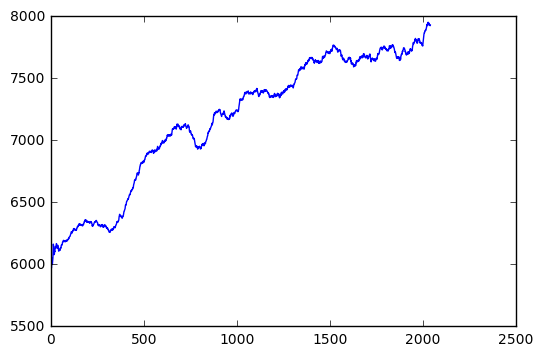

In [36]:
plt.plot(batch_sizes_mean)
plt.show()

In [15]:
while True:
    X_batch, y_batch, results = play_n_games(agent, n=5, report_score=True)
    vf_batch = random.sample(list(zip(X_batch[:-1], y_batch[:-1], results[:-1], X_batch[1:])), 255)
    vf_batch.append([X_batch[-1], y_batch[-1], results[-1], X_batch[0]])
    agent.train_val_func(vf_batch[::-1])
    rdd_sample = to_rdd.to_RDD(X_batch, y_batch, sc)
    batch_size = X_batch.shape[0] - X_batch.shape[0]%4
    batch_sizes.append(batch_size)
    batch_sizes_mean.append(np.mean(batch_sizes))
    print(t, np.sum(results)/5, batch_size,np.mean(batch_sizes))
    if np.sum(results)/5 >= 2:
        break
    
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=PGCriterion(),
                                  optim_method=Adam(learningrate=0.0002),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    agent.model = optimizer.optimize()
    agent.model.evaluate()
    if t % 50 == 0:
        save_name = 'Actor_critic_Pong'+str(t)
        agent.model.save(save_name)
        agent.value_func.save('vf_func'+str(t))
    t += 1

Score is 21 : 2
Score is 21 : 3
Score is 21 : 4
Score is 21 : 2
Score is 21 : 6
2282 -17.6 8784 7870.84
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 3
Score is 21 : 1
Score is 21 : 2
Score is 21 : 1
Score is 21 : 0
2283 -19.6 8036 7868.28
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 1
Score is 21 : 4
Score is 21 : 7
Score is 21 : 1
Score is 21 : 2
2284 -18.0 8400 7864.16
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 1
Score is 21 : 1
Score is 21 : 6
Score is 21 : 2
Score is 21 : 0
2285 -19.0 8472 7872.92
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 0
Score is 21 : 2
Score is 21 : 2
Score is 21 : 1
Score is 21 : 0
2286 -20.0 7320 7867.72
creating: createPGCriterion
creating: createAdam
creating: creat

KeyboardInterrupt: 

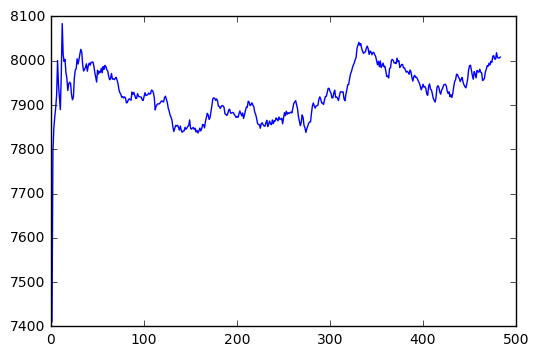

In [19]:
plt.plot(batch_sizes_mean)
plt.show()

In [18]:
while True:
    X_batch, y_batch, results = play_n_games(agent, n=5, report_score=True)
    vf_batch = random.sample(list(zip(X_batch[:-1], y_batch[:-1], results[:-1], X_batch[1:])), 255)
    vf_batch.append([X_batch[-1], y_batch[-1], results[-1], X_batch[0]])
    agent.train_val_func(vf_batch[::-1])
    rdd_sample = to_rdd.to_RDD(X_batch, y_batch, sc)
    batch_size = X_batch.shape[0] - X_batch.shape[0]%4
    batch_sizes.append(batch_size)
    batch_sizes_mean.append(np.mean(batch_sizes))
    print(t, np.sum(results)/5, batch_size,np.mean(batch_sizes))
    if np.sum(results)/5 >= 2:
        break
    
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=PGCriterion(),
                                  optim_method=Adam(learningrate=0.0001),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    agent.model = optimizer.optimize()
    agent.model.evaluate()
    if t % 50 == 0:
        save_name = 'Actor_critic_Pong'+str(t)
        agent.model.save(save_name)
        agent.value_func.save('vf_func'+str(t))
    t += 1

Score is 21 : 3
Score is 21 : 1
Score is 21 : 1
Score is 21 : 0
Score is 21 : 5
2451 -19.0 7580 7914.88
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 3
Score is 21 : 0
Score is 21 : 1
Score is 21 : 2
Score is 21 : 1
2452 -19.6 7744 7910.88
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 1
Score is 21 : 0
Score is 21 : 0
Score is 21 : 0
Score is 21 : 2
2453 -20.4 7220 7906.6
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 0
Score is 21 : 1
Score is 21 : 3
Score is 21 : 4
Score is 21 : 5
2454 -18.4 8592 7918.2
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 3
Score is 21 : 4
Score is 21 : 3
Score is 21 : 4
Score is 21 : 6
2455 -17.0 9060 7940.36
creating: createPGCriterion
creating: createAdam
creating: createM

KeyboardInterrupt: 

In [ ]:
while True:
    X_batch, y_batch, results = play_n_games(agent, n=5, report_score=True)
    vf_batch = random.sample(list(zip(X_batch[:-1], y_batch[:-1], results[:-1], X_batch[1:])), 255)
    vf_batch.append([X_batch[-1], y_batch[-1], results[-1], X_batch[0]])
    agent.train_val_func(vf_batch[::-1])
    rdd_sample = to_rdd.to_RDD(X_batch, y_batch, sc)
    batch_size = X_batch.shape[0] - X_batch.shape[0]%4
    batch_sizes.append(batch_size)
    batch_sizes_mean.append(np.mean(batch_sizes))
    print(t, np.sum(results)/5, batch_size,np.mean(batch_sizes))
    if np.sum(results)/5 >= 2:
        break
    
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=PGCriterion(),
                                  optim_method=Adam(learningrate=0.0001),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    agent.model = optimizer.optimize()
    agent.model.evaluate()
    if t % 50 == 0:
        save_name = 'Actor_critic_Pong'+str(t)
        agent.model.save(save_name)
        agent.value_func.save('vf_func'+str(t))
    t += 1

Score is 21 : 5
Score is 21 : 3
Score is 21 : 2
Score is 21 : 1
Score is 21 : 3
2525 -18.2 8848 8848.0
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 4
Score is 21 : 1
Score is 21 : 0
Score is 21 : 0
Score is 21 : 1
2526 -19.8 7228 8038.0
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 2
Score is 21 : 3
Score is 21 : 2
Score is 21 : 2
Score is 21 : 2
2527 -18.8 8376 8150.66666667
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 0
Score is 21 : 4
Score is 21 : 2
Score is 21 : 1
Score is 21 : 2
2528 -19.2 8248 8175.0
creating: createPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Score is 21 : 1
Score is 21 : 3
Score is 21 : 2
Score is 21 : 1
Score is 21 : 3
2529 -19.0 7928 8125.6
creating: createPGCriterion
creating: createAdam
creating: cre

In [13]:
state = env.reset()
mean = []
for _ in range(20):
    print(agent.model.forward(state), agent.act(state))
    mean.append(agent.model.forward(state))
    state, _, _, _ = env.step(env.action_space.sample())
print(np.mean(mean))

[ 0.14969562  0.11557361  0.16760981  0.18338972  0.23214066  0.15159059] 0
[ 0.14956394  0.11990034  0.16797379  0.19292791  0.21540743  0.15422656] 1
[ 0.12910201  0.11955591  0.20048957  0.13193825  0.29762825  0.12128601] 1
[ 0.14846243  0.11914083  0.1679077   0.19446622  0.21437415  0.15564863] 0
[ 0.14583375  0.11720931  0.16912062  0.19409482  0.21579333  0.1579482 ] 2
[ 0.14270094  0.11501213  0.1705505   0.19350478  0.21748589  0.16074584] 2
[ 0.14209533  0.11461323  0.17080912  0.19339646  0.21778251  0.16130328] 2
[ 0.1285567   0.11895671  0.20254412  0.12771173  0.30406085  0.11816979] 4
[ 0.14273022  0.11520807  0.17010443  0.1928319   0.21794665  0.16117863] 3
[ 0.12946337  0.11899532  0.20153102  0.1285737   0.30278313  0.11865345] 0
[ 0.14221954  0.11631221  0.17339683  0.18391079  0.22792703  0.15623359] 0
[ 0.12917192  0.11909521  0.20105609  0.12935825  0.30191475  0.11940383] 4
[ 0.14179304  0.11485881  0.17195176  0.19065797  0.22091174  0.15982671] 4
[ 0.14158495

In [20]:
for a, b in list(zip(X_batch, y_batch)):
    print(agent.model.forward(a), b)

[ 0.5251624] [ 1.          0.00359611]
[ 0.5251624] [ 0.          0.00285085]
[ 0.5251624] [ 1.          0.00206637]
[ 0.5251624] [ 1.         0.0012406]
[ 0.5251624] [  1.00000000e+00   3.71372327e-04]
[ 0.5251624] [ 0.         -0.00054361]
[ 0.5251624] [ 1.         -0.00150674]
[ 0.5251624] [ 1.         -0.00252057]
[ 0.5251624] [ 1.         -0.00358776]
[ 0.5251624] [ 0.         -0.00471111]
[ 0.5251624] [ 1.         -0.00589359]
[ 0.5251624] [ 1.        -0.0071383]
[ 0.5251624] [ 0.         -0.00844853]
[ 0.5251624] [ 1.         -0.00982771]
[ 0.5251624] [ 1.         -0.01127949]
[ 0.5251624] [ 0.         -0.01280767]
[ 0.5251624] [ 1.         -0.01441628]
[ 0.5251624] [ 0.         -0.01610956]
[ 0.5251624] [ 0.         -0.01789195]
[ 0.5251624] [ 0.         -0.01976816]
[ 0.5251624] [ 0.         -0.02174312]
[ 0.5251624] [ 1.         -0.02382202]
[ 0.5251624] [ 0.         -0.02601033]
[ 0.5251624] [ 0.         -0.02831382]
[ 0.5251624] [ 0.         -0.03073855]
[ 0.5251624] [ 0.  

KeyboardInterrupt: 

In [12]:
a, b, c =play_game(agent, render=True)

In [12]:
state = env.reset()
#print(state)
agent.model.forward(state)

array([ 0.16578086,  0.19304466,  0.16255569,  0.12852633,  0.16881527,
        0.18127736], dtype=float32)